# XBeach data forcing

Demo notebook with usage examples

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import warnings
warnings.filterwarnings("ignore")

In [3]:
datadir = Path("../../../rompy-xbeach/tests/data")
outdir = Path("forcing-demo")
outdir.mkdir(exist_ok=True, parents=True)

## Overview

XBeach forcing objects provide an interface to generate model forcing from existing data.


### 1. Wind input

### 2. Water level input

## Interfaces

XBeach forcing interfaces are intantiated with a `Source` instance plus some parameters
that are specific to each input forcing. They all have a `get()` method which
takes as inputs the workspace `destdir` directory, the model `grid`, and the model `time`.
The source data are sliced over the model times and at the location of either the
centre of the grid or the offshore boundary middle point. The sliced data are used to
create XBeach forcing files and instructions. The method returns a dictionary with the
key-value pair to write in the XBeach params file.

Let's start off by defining some input source, time and grid objects to use with
the different boundary objects. The `spectra` and `param` prefixes indicate objects to
use with boundary objects based on spectra and integrated parameters data, respectively

In [4]:
from rompy.core.time import TimeRange
from rompy_xbeach.grid import RegularGrid, Ori
from rompy_xbeach.source import SourceCRSFile

In [5]:
# Data source
source_wind_grid = SourceCRSFile(
    uri="../../../rompy-xbeach/tests/data/era5-20230101.nc",
    crs=4326,
)
source_wind_station = SourceCRSFile(
    uri="../../../rompy-xbeach/tests/data/smc-params-20230101.nc",
    crs=4326,
)

# Model times
times = TimeRange(start="2023-01-01T00", end="2023-01-01T12", interval="1h")

# Model grid
grid = RegularGrid(
    ori=dict(x=115.594239, y=-32.641104, crs="epsg:4326"),
    alfa=347.0,
    dx=10,
    dy=15,
    nx=230,
    ny=220,
    crs="28350",
)

## Wind forcing

Wind forcing interfaces in rompy-xbeach generate wind data from existing data sources
at a single location within the grid. Two location options are available: the centre
or the middle point of the offshore boundary.

Wind data can be generated from gridded and station type input data.

### WindStation

XBeach wind forcing from stations type data sources.

In [6]:
from rompy_xbeach.forcing import WindGrid, WindStation, WindVector, WindScalar

In [7]:
destdir = outdir / "wind_station"
destdir.mkdir(exist_ok=True)


# Wind data can be prescribed from vector or scalar fields. The different type
# of fields are defined by the `WindVector` and `WindScalar` objects. We are going to
# work with a source data that with wind vector variables and so we are going to use
# the `WindVector` object.
wind_vars = WindVector(u="uwnd", v="vwnd")

# Instantiate a wind data object using the stations source, make sure the station
# coordinate 's' is correctly specified
wind = WindStation(
    id="test",
    source=source_wind_station,
    coords=dict(s="seapoint"),
    wind_vars=wind_vars,
)

# Generate the XBeach windfile and return the params instruction
namelist = wind.get(destdir=destdir, grid=grid, time=times)
namelist

{'windfile': 'windfile-20230101T000000-20230101T120000.txt'}

In [8]:
windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       7.15     186.92
   3600.00       7.49     192.82
   7200.00       7.96     198.03
  10800.00       8.24     203.33
  14400.00       8.91     208.57
  18000.00       9.69     210.79
  21600.00      10.09     210.59
  25200.00      10.29     210.61
  28800.00      10.20     209.83
  32400.00      10.26     209.25
  36000.00      10.74     209.04
  39600.00      11.03     204.15
  43200.00      10.76     199.61



By default the source data are generated at the centre of the model grid but we can choose
to define it at the offshore grid boundary instead

In [9]:
wind = WindStation(
    id="test",
    source=source_wind_station,
    coords=dict(s="seapoint"),
    wind_vars=wind_vars,
    sel_method="idw",
    sel_method_kwargs=dict(tolerance=0.2),
    location="offshore",
)

namelist = wind.get(destdir=destdir, grid=grid, time=times)

windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       7.29     186.73
   3600.00       7.62     192.53
   7200.00       8.08     197.69
  10800.00       8.35     202.92
  14400.00       9.01     208.16
  18000.00       9.79     210.39
  21600.00      10.20     210.32
  25200.00      10.38     210.36
  28800.00      10.30     209.63
  32400.00      10.36     209.09
  36000.00      10.85     208.87
  39600.00      11.16     204.00
  43200.00      10.91     199.48



An Inverse Distance Weighting (IDW) algorithm is used to interpolate the source data
by default, but a nearest neighbour selection is also supported.

The station data selection use selection functions defined in wavespectra:
[sel_nearest](https://github.com/wavespectra/wavespectra/blob/master/wavespectra/core/select.py#L150) and [sel_idw](https://github.com/wavespectra/wavespectra/blob/master/wavespectra/core/select.py#L234)

In [10]:
wind = WindStation(
    id="test",
    source=source_wind_station,
    coords=dict(s="seapoint"),
    wind_vars=wind_vars,
    sel_method="nearest",
    sel_method_kwargs=dict(tolerance=0.2),
)

namelist = wind.get(destdir=destdir, grid=grid, time=times)

windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       6.56     187.88
   3600.00       6.91     194.24
   7200.00       7.43     199.65
  10800.00       7.74     205.24
  14400.00       8.47     210.50
  18000.00       9.26     212.66
  21600.00       9.66     211.88
  25200.00       9.88     211.76
  28800.00       9.78     210.76
  32400.00       9.81     209.96
  36000.00      10.26     209.81
  39600.00      10.47     204.85
  43200.00      10.12     200.22



Let's plot the original source data and the selected data

In [44]:
# Generated wind data
df = pd.read_csv(windfile, header=None, sep="\s+", names=["tsec", "wspd", "wdir"])
df.index = [times.start + timedelta(seconds=s) for s in df.tsec]
display(df)

# Source dataset
dset = source_wind_station.open().sel(time=slice(times.start, times.end))
display(dset[["uwnd", "vwnd", "longitude", "latitude"]])

,tsec,wspd,wdir
2023-01-01 00:00:00,0.0,6.56,187.88
2023-01-01 01:00:00,3600.0,6.91,194.24
2023-01-01 02:00:00,7200.0,7.43,199.65
2023-01-01 03:00:00,10800.0,7.74,205.24
2023-01-01 04:00:00,14400.0,8.47,210.50
2023-01-01 05:00:00,18000.0,9.26,212.66
2023-01-01 06:00:00,21600.0,9.66,211.88
2023-01-01 07:00:00,25200.0,9.88,211.76
2023-01-01 08:00:00,28800.0,9.78,210.76
2023-01-01 09:00:00,32400.0,9.81,209.96


<xarray.Dataset> Size: 10kB
Dimensions:      (time: 13, seapoint: 91)
Coordinates:
  * time         (time) datetime64[ns] 104B 2023-01-01 ... 2023-01-01T12:00:00
    spatial_ref  int64 8B 0
Dimensions without coordinates: seapoint
Data variables:
    uwnd         (time, seapoint) float32 5kB ...
    vwnd         (time, seapoint) float32 5kB ...
    longitude    (seapoint) float32 364B ...
    latitude     (seapoint) float32 364B ...
Attributes: (12/20)
    WAVEWATCH_III_version_number:  6.07
    WAVEWATCH_III_switches:        O0 O1 IS0 IC0 SMC RWND REF0 LN1 FLX4 ST6 M...
    first_lat:                     -74.96875
    first_lon:                     -179.96875
    base_lat_size:                 0.0625
    base_lon_size:                 0.0625
    ...                            ...
    maximum_altitude:              9000 m
    altitude_resolution:           n/a
    start_date:                    2001-01-01 00:00:00
    stop_date:                     2001-02-01 00:00:00
    history:                       Wed Nov 13 16:42:53 2024: ncks -d time,0,2...
    NCO:                           netCDF Operators version 5.0.6 (Homepage =...

Plot the source and generated data

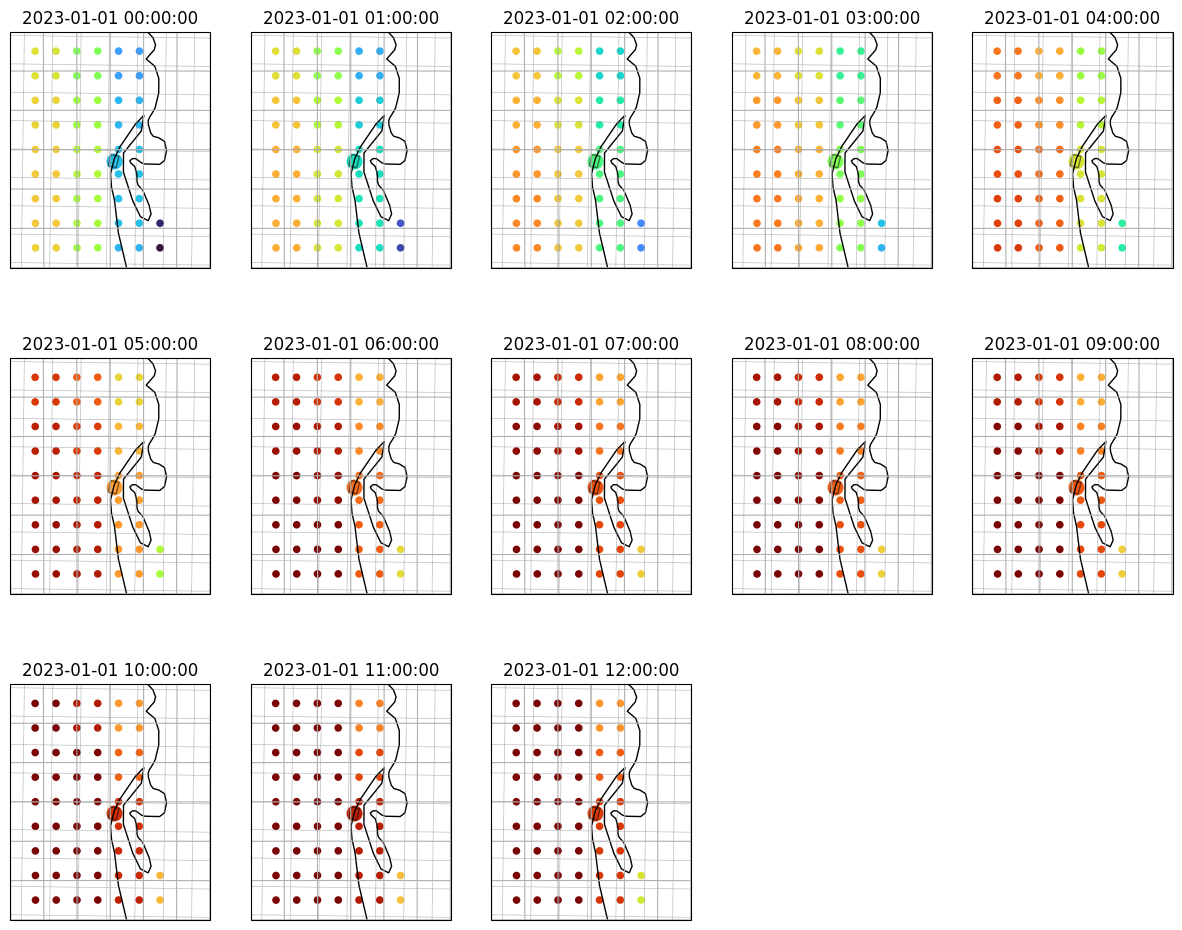

In [ ]:
vmin = 5
vmax = 11
cmap = "turbo"

wspd = (dset.uwnd ** 2 + dset.vwnd ** 2) ** 0.5

fig, axs = plt.subplots(3, 5, figsize=(15, 12), subplot_kw=dict(projection=grid.projection))

for i, ax in enumerate(axs.flat):
    if i > df.shape[0] - 1:
        ax.axis("off")
        continue

    ax.coastlines()

    # Plot the source data
    source_data = wspd.isel(time=i)
    ax.scatter(
        dset.longitude,
        dset.latitude,
        s=20,
        c=source_data,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Plot the generated data
    generated_data = df.loc[df.index[i]]
    ax.scatter(
        grid.centre[0],
        grid.centre[1],
        s=110,
        c=generated_data.wspd,
        transform=grid.transform,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Plot the grid
    ax = grid.plot(
        ax=ax,
        grid_kwargs=dict(facecolor="none", edgecolor="black", alpha=0.5),
        set_gridlines=False,
        show_origin=False,
        show_offshore=False,
    )

    ax.set_extent([115.3, 115.9, -32.9, -32.3])
    ax.set_title(f"{generated_data.name}")
    ax.gridlines(draw_labels=False)

### WindGrid

XBeach wind forcing from gridded type data sources.

In [72]:
# The WindGrid object should be used if the source data is a gridded dataset
wind = WindGrid(
    id="test",
    source=source_wind_grid,
    coords=dict(x="longitude", y="latitude"),
    wind_vars=WindVector(u="u10", v="v10"),
    sel_method="sel",
    sel_method_kwargs=dict(method="nearest"),
)

namelist = wind.get(destdir=destdir, grid=grid, time=times)

windfile = destdir / namelist["windfile"]
print(windfile.read_text())

      0.00       6.97     187.42
  21600.00       6.31     178.52
  43200.00       7.23     167.43



In [73]:
# Generated wind data
df = pd.read_csv(windfile, header=None, sep="\s+", names=["tsec", "wspd", "wdir"])
df.index = [times.start + timedelta(seconds=s) for s in df.tsec]
display(df)

# Source dataset
dset = source_wind_grid.open().sel(time=slice(times.start, times.end))
display(dset)

,tsec,wspd,wdir
2023-01-01 00:00:00,0.0,6.97,187.42
2023-01-01 06:00:00,21600.0,6.31,178.52
2023-01-01 12:00:00,43200.0,7.23,167.43


<xarray.Dataset> Size: 128kB
Dimensions:      (latitude: 37, longitude: 72, time: 3)
Coordinates:
  * latitude     (latitude) float32 148B 90.0 85.0 80.0 ... -80.0 -85.0 -90.0
  * longitude    (longitude) float32 288B 0.0 5.0 10.0 ... 345.0 350.0 355.0
  * time         (time) datetime64[ns] 24B 2023-01-01 ... 2023-01-01T12:00:00
    spatial_ref  int64 8B 0
Data variables:
    u10          (time, latitude, longitude) float64 64kB ...
    v10          (time, latitude, longitude) float64 64kB ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-06-10 00:03:38 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

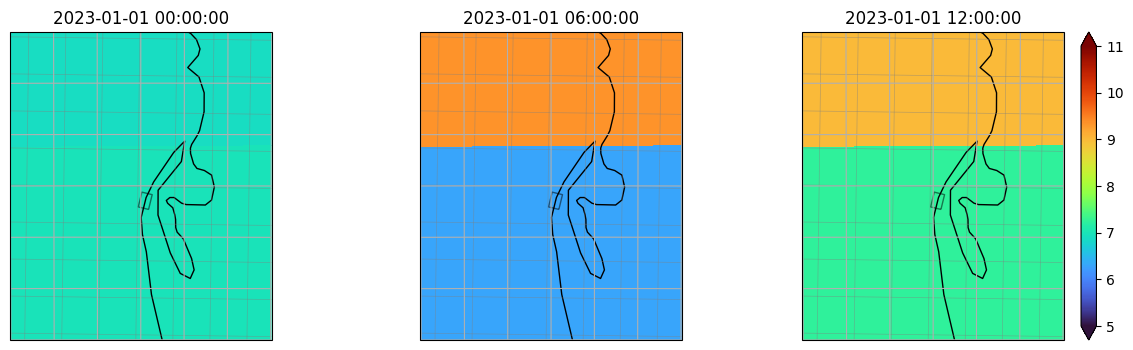

In [74]:
vmin = 5
vmax = 11
cmap = "turbo"

wspd = (dset.u10 ** 2 + dset.v10 ** 2) ** 0.5

fig, axs = plt.subplots(1, 3, figsize=(15, 4), subplot_kw=dict(projection=grid.projection))

for i, ax in enumerate(axs.flat):
    if i > df.shape[0] - 1:
        ax.axis("off")
        continue

    ax.coastlines()

    # Plot the source data
    source_data = wspd.isel(time=i)
    source_data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
        add_colorbar=True if i == 2 else False,
    )

    # Plot the generated data
    generated_data = df.loc[df.index[i]]
    ax.scatter(
        grid.centre[0],
        grid.centre[1],
        s=110,
        c=generated_data.wspd,
        transform=grid.transform,
        vmin=vmin,
        vmax=vmax,
        cmap=cmap,
    )

    # Plot the grid
    ax = grid.plot(
        ax=ax,
        grid_kwargs=dict(facecolor="none", edgecolor="black", alpha=0.5),
        set_gridlines=False,
        show_origin=False,
        show_offshore=False,
    )

    ax.set_extent([115.3, 115.9, -32.9, -32.3])
    ax.set_title(f"{generated_data.name}")
    ax.gridlines(draw_labels=False)